In [36]:
# 03_teacher_student_transfer.ipynb
'''Implement teacher-student knowledge distillation on the processed dataset.  
- Loads processed train/test split created by earlier notebooks.
- Trains a strong teacher (RandomForest & optional XGBoost ensemble).
- Generates soft labels (with temperature) from teacher.
- Trains a compact student model to mimic teacher soft targets.
- Evaluates and saves models + metrics.'''


'Implement teacher-student knowledge distillation on the processed dataset.  \n- Loads processed train/test split created by earlier notebooks.\n- Trains a strong teacher (RandomForest & optional XGBoost ensemble).\n- Generates soft labels (with temperature) from teacher.\n- Trains a compact student model to mimic teacher soft targets.\n- Evaluates and saves models + metrics.'

In [37]:
# Standard imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import time
import json
from pprint import pprint

# Data science
import numpy as np
import pandas as pd

# Sklearn & modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss
from sklearn.pipeline import Pipeline
import joblib

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Try to import PyTorch for student model
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

# Repro
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TORCH_AVAILABLE:
    torch.manual_seed(RANDOM_SEED)

# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"
for d in (MODELS_DIR, REPORTS_DIR):
    d.mkdir(parents=True, exist_ok=True)


In [38]:
#Utilities
def load_splits():
    X_train = pd.read_csv(DATA_DIR / "X_train.csv")
    X_test  = pd.read_csv(DATA_DIR / "X_test.csv")
    y_train = pd.read_csv(DATA_DIR / "y_train.csv").squeeze()
    y_test  = pd.read_csv(DATA_DIR / "y_test.csv").squeeze()
    return X_train, X_test, y_train, y_test

def save_joblib(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(obj, path)
    print(f"Saved: {path}")

def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"Saved: {path}")

def ensure_numpy(arr):
    if isinstance(arr, pd.Series) or isinstance(arr, pd.DataFrame):
        return arr.values
    return np.asarray(arr)

timestamp = time.strftime("%Y%m%d_%H%M%S")


In [39]:
#Load data & label encode
X_train, X_test, y_train, y_test = load_splits()
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
save_joblib(le, MODELS_DIR / f"label_encoder_{timestamp}.joblib")

n_classes = len(le.classes_)
print("Classes (n={}): {}".format(n_classes, le.classes_))


Shapes: (1158, 54) (290, 54) (1158,) (290,)
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\models\label_encoder_20251017_231950.joblib
Classes (n=2): [0 1]


In [40]:
# Scaling is useful for student neural net; teacher (tree-based) is fine without scaling,
# but to keep consistency we scale for student training; we will feed raw X to teacher if desired.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
save_joblib(scaler, MODELS_DIR / f"scaler_{timestamp}.joblib")

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Saved: C:\Users\alfiy\ByteBuzz\Notebooks\models\scaler_20251017_231950.joblib
Scaled shapes: (1158, 54) (290, 54)


In [41]:
#Build & train teacher model
# We'll train a strong teacher composed of a RandomForest and (optionally) XGBoost.
# Final teacher prediction will be an average of predicted probabilities (soft ensemble).
teacher_models = {}

# RandomForest teacher
rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_SEED, n_jobs=-1)
print("Training RandomForest teacher...")
rf.fit(X_train, y_train_enc)   # tree-based: use raw features (no scaling)
teacher_models['rf'] = rf
save_joblib(rf, MODELS_DIR / f"teacher_rf_{timestamp}.joblib")

# Optional XGBoost teacher
if XGBOOST_AVAILABLE:
    xgb_clf = xgb.XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_SEED, n_jobs=1)
    print("Training XGBoost teacher...")
    xgb_clf.fit(X_train, y_train_enc)
    teacher_models['xgb'] = xgb_clf
    save_joblib(xgb_clf, MODELS_DIR / f"teacher_xgb_{timestamp}.joblib")
else:
    print("XGBoost not available — skipping.")

# Teacher predict_proba function (averaged)
def teacher_predict_proba(X):
    # X assumed to be raw (not scaled)
    probs = []
    for m in teacher_models.values():
        probs.append(m.predict_proba(X))
    avg = np.mean(probs, axis=0)
    return avg

# Evaluate teacher on test
teacher_probs_test = teacher_predict_proba(X_test)
teacher_preds_test = np.argmax(teacher_probs_test, axis=1)
teacher_acc = accuracy_score(y_test_enc, teacher_preds_test)
teacher_f1 = f1_score(y_test_enc, teacher_preds_test, average='macro')
print(f"Teacher — accuracy: {teacher_acc:.4f}, f1_macro: {teacher_f1:.4f}")


Training RandomForest teacher...
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\models\teacher_rf_20251017_231950.joblib
XGBoost not available — skipping.
Teacher — accuracy: 0.7690, f1_macro: 0.4983


In [42]:
#create softlables
def softmax_with_temp(logits, T=1.0):
    # logits shape: (n_samples, n_classes)
    ex = np.exp(logits / T - np.max(logits / T, axis=1, keepdims=True))
    return ex / np.sum(ex, axis=1, keepdims=True)

# For tree models, logits not directly available. We'll use predicted probabilities and adjust:
# Convert probabilities into "soft targets" using temperature by raising probabilities to 1/T then re-normalizing.
def soften_probs(probs, T=2.0):
    # probs shape (n, c)
    if T == 1.0:
        return probs
    powered = np.power(probs, 1.0 / T)
    return powered / powered.sum(axis=1, keepdims=True)

# Choose temperature
TEMP = 2.0
teacher_soft_train = soften_probs(teacher_predict_proba(X_train), T=TEMP)
teacher_soft_test  = soften_probs(teacher_predict_proba(X_test), T=TEMP)

# As a sanity check, the soft labels should be probability distributions
print("Soft targets sample (train):")
print(teacher_soft_train[:3])


Soft targets sample (train):
[[0.16579679 0.83420321]
 [0.26968623 0.73031377]
 [0.64022475 0.35977525]]


In [43]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [44]:
# Recheck PyTorch availability (rerun this if you just installed PyTorch)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
    print("PyTorch is available! Version:", torch.__version__)
except Exception as e:
    TORCH_AVAILABLE = False
    print("PyTorch not available:", e)


PyTorch is available! Version: 2.9.0+cpu


In [45]:
#Student model: PyTorch MLP
if TORCH_AVAILABLE:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Torch available. Using device:", device)

    class StudentNet(nn.Module):
        def __init__(self, n_features, n_classes, hidden_units=128, dropout=0.2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(n_features, hidden_units),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_units, max(32, hidden_units//4)),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(max(32, hidden_units//4), n_classes),
            )
        def forward(self, x):
            return self.net(x)

    # Training function: minimize KL divergence between soft teacher probs and student outputs (with temp)
    def train_student_torch(X_train_np, soft_targets, X_val_np, soft_val, n_epochs=60, batch_size=64, lr=1e-3, temp=TEMP):
        X_tr_t = torch.tensor(X_train_np, dtype=torch.float32).to(device)
        y_soft_t = torch.tensor(soft_targets, dtype=torch.float32).to(device)
        X_val_t = torch.tensor(X_val_np, dtype=torch.float32).to(device)
        y_soft_val = torch.tensor(soft_val, dtype=torch.float32).to(device)

        model = StudentNet(n_features=X_train_np.shape[1], n_classes=soft_targets.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Use KLDivLoss between log_softmax(student_logits/temp) and teacher_soft (already softened)
        kl_loss = nn.KLDivLoss(reduction="batchmean")
        ce_loss = nn.CrossEntropyLoss()

        # DataLoader style batching (simple)
        n = X_train_np.shape[0]
        idx = np.arange(n)

        best_val_loss = float("inf")
        best_state = None
        history = {"train_loss": [], "val_loss": []}

        for epoch in range(1, n_epochs+1):
            model.train()
            np.random.shuffle(idx)
            train_loss = 0.0
            for i in range(0, n, batch_size):
                batch_idx = idx[i:i+batch_size]
                xb = X_tr_t[batch_idx]
                yb_soft = y_soft_t[batch_idx]

                logits = model(xb)  # shape (b, c)
                # compute log-softmax with temperature
                log_probs = nn.functional.log_softmax(logits / temp, dim=1)
                loss_kl = kl_loss(log_probs, yb_soft)
                # Optionally also add hard-label cross-entropy to stabilize (mixing)
                hard_labels = torch.argmax(yb_soft, dim=1)
                loss_ce = ce_loss(logits, hard_labels)
                loss = 0.7 * loss_kl + 0.3 * loss_ce

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb.size(0)
            train_loss /= n

            # Validation
            model.eval()
            with torch.no_grad():
                val_logits = model(X_val_t)
                val_log_probs = nn.functional.log_softmax(val_logits / temp, dim=1)
                val_loss = kl_loss(val_log_probs, y_soft_val).item()

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)

            # simple early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch}/{n_epochs} — train_loss: {train_loss:.4f} — val_loss: {val_loss:.4f}")

        # load best state
        model.load_state_dict(best_state)
        return model, history

    # Prepare student inputs: use scaled features
    X_tr_np = X_train_scaled.values.astype(np.float32)
    X_te_np = X_test_scaled.values.astype(np.float32)
    # split training into train/val for student training
    from sklearn.model_selection import train_test_split
    X_s_tr, X_s_val, soft_tr, soft_val = train_test_split(X_tr_np, teacher_soft_train, test_size=0.15, random_state=RANDOM_SEED, stratify=y_train_enc if n_classes>1 else None)

    print("Training student (PyTorch MLP)...")
    student_model, hist = train_student_torch(X_s_tr, soft_tr, X_s_val, soft_val, n_epochs=80, batch_size=64, lr=1e-3, temp=TEMP)
    # Save student model
    student_path = MODELS_DIR / f"student_mlp_{timestamp}.pt"
    torch.save(student_model.state_dict(), student_path)
    print("Saved student PyTorch model to:", student_path)

else:
    print("PyTorch not available — falling back to LogisticRegression student (train on softened probabilities via multi-label regression approximation).")
    # We'll train LogisticRegression on hard labels but with teacher's soft labels as sample weights proxy is tricky.
    # Simpler and robust: train LogisticRegression on original hard labels (this is a compact student baseline).
    student_lr = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
    ])
    print("Training LogisticRegression student on hard labels...")
    student_lr.fit(X_train, y_train_enc)
    student_path = MODELS_DIR / f"student_logreg_{timestamp}.joblib"
    save_joblib(student_lr, student_path)


Torch available. Using device: cpu
Training student (PyTorch MLP)...
Epoch 1/80 — train_loss: 0.2825 — val_loss: 0.0950
Epoch 10/80 — train_loss: 0.1576 — val_loss: 0.0633
Epoch 20/80 — train_loss: 0.1302 — val_loss: 0.0674
Epoch 30/80 — train_loss: 0.1092 — val_loss: 0.0800
Epoch 40/80 — train_loss: 0.1018 — val_loss: 0.0859
Epoch 50/80 — train_loss: 0.0870 — val_loss: 0.0859
Epoch 60/80 — train_loss: 0.0843 — val_loss: 0.0847
Epoch 70/80 — train_loss: 0.0765 — val_loss: 0.0845
Epoch 80/80 — train_loss: 0.0732 — val_loss: 0.0846
Saved student PyTorch model to: C:\Users\alfiy\ByteBuzz\Notebooks\models\student_mlp_20251017_231950.pt


In [46]:
#Evaluate student & teacher on test set
# Teacher metrics (already partially computed) — recompute for clarity
teacher_probs_test = teacher_predict_proba(X_test)
teacher_preds_test = np.argmax(teacher_probs_test, axis=1)
teacher_acc = accuracy_score(y_test_enc, teacher_preds_test)
teacher_f1 = f1_score(y_test_enc, teacher_preds_test, average='macro')

# Student predictions
if TORCH_AVAILABLE:
    # load model into evaluation mode (we have model in memory)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_scaled.values.astype(np.float32)).to(device)
        logits = student_model(X_test_t)
        student_probs = torch.softmax(logits, dim=1).cpu().numpy()
    student_preds = np.argmax(student_probs, axis=1)
    student_acc = accuracy_score(y_test_enc, student_preds)
    student_f1 = f1_score(y_test_enc, student_preds, average='macro')
else:
    student_preds = student_lr.predict(X_test)
    student_probs = student_lr.predict_proba(X_test)
    student_acc = accuracy_score(y_test_enc, student_preds)
    student_f1 = f1_score(y_test_enc, student_preds, average='macro')

print("Teacher — accuracy: {:.4f}, f1_macro: {:.4f}".format(teacher_acc, teacher_f1))
print("Student — accuracy: {:.4f}, f1_macro: {:.4f}".format(student_acc, student_f1))

# Detailed reports
teacher_report = classification_report(y_test_enc, teacher_preds_test, output_dict=True, zero_division=0)
student_report = classification_report(y_test_enc, student_preds, output_dict=True, zero_division=0)

# Save metrics and reports
summary = {
    "timestamp": timestamp,
    "n_classes": n_classes,
    "temperature": TEMP,
    "teacher_accuracy": float(teacher_acc),
    "teacher_f1_macro": float(teacher_f1),
    "student_accuracy": float(student_acc),
    "student_f1_macro": float(student_f1),
    "teacher_models": list(teacher_models.keys()),
    "student_model_path": str(student_path)
}
save_json(summary, REPORTS_DIR / f"distill_summary_{timestamp}.json")
save_json({"teacher_report": teacher_report, "student_report": student_report}, REPORTS_DIR / f"distill_reports_{timestamp}.json")


Teacher — accuracy: 0.7690, f1_macro: 0.4983
Student — accuracy: 0.7724, f1_macro: 0.6134
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\reports\distill_summary_20251017_231950.json
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\reports\distill_reports_20251017_231950.json


In [47]:
# Train a compact baseline student on hard labels (LogReg) for comparison if PyTorch was used for distilled student
if TORCH_AVAILABLE:
    baselog = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
    baselog.fit(X_train_scaled, y_train_enc)
    base_preds = baselog.predict(X_test_scaled)
    base_acc = accuracy_score(y_test_enc, base_preds)
    base_f1 = f1_score(y_test_enc, base_preds, average='macro')
    print("Baseline LogReg on hard labels — acc: {:.4f}, f1: {:.4f}".format(base_acc, base_f1))
    summary["baseline_logreg_accuracy"] = float(base_acc)
    summary["baseline_logreg_f1_macro"] = float(base_f1)
    save_json(summary, REPORTS_DIR / f"distill_summary_{timestamp}.json")
    save_joblib(baselog, MODELS_DIR / f"baseline_logreg_{timestamp}.joblib")


Baseline LogReg on hard labels — acc: 0.7759, f1: 0.5977
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\reports\distill_summary_20251017_231950.json
Saved: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_logreg_20251017_231950.joblib


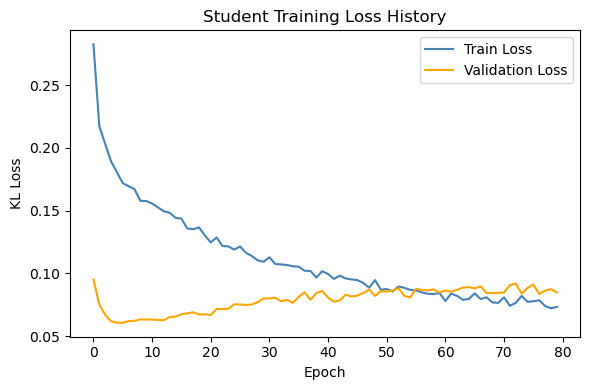

,model,accuracy,f1_macro
0,teacher,0.768966,0.498335
1,student,0.772414,0.613365
2,baseline_logreg,0.775862,0.597661


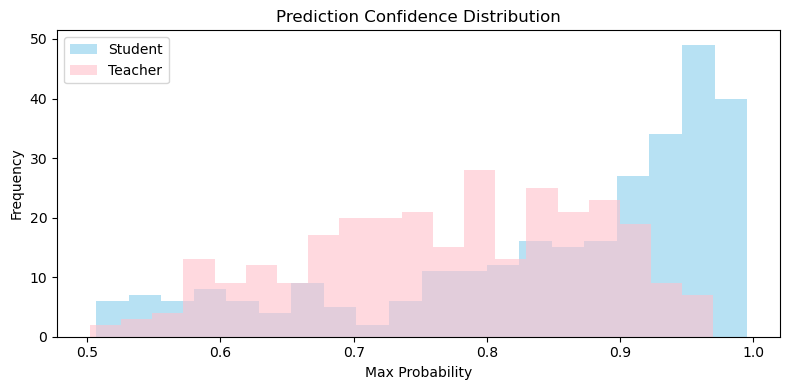

In [49]:
#visualization and analysis
# Visualization and analysis
import matplotlib.pyplot as plt

# Student training loss history (if available)
if TORCH_AVAILABLE and 'hist' in locals() and isinstance(hist, dict):
    if "train_loss" in hist and "val_loss" in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist["train_loss"], label="Train Loss", color='steelblue')
        plt.plot(hist["val_loss"], label="Validation Loss", color='orange')
        plt.xlabel("Epoch")
        plt.ylabel("KL Loss")
        plt.title("Student Training Loss History")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("`hist` exists but missing train/val loss keys.")
else:
    print(" No `hist` data available — run the student training cell first.")

# Accuracy/F1 summary
df_summary = pd.DataFrame([
    {"model": "teacher", "accuracy": summary["teacher_accuracy"], "f1_macro": summary["teacher_f1_macro"]},
    {"model": "student", "accuracy": summary["student_accuracy"], "f1_macro": summary["student_f1_macro"]},
])
if "baseline_logreg_accuracy" in summary:
    df_summary = pd.concat([
        df_summary,
        pd.DataFrame([{
            "model": "baseline_logreg",
            "accuracy": summary["baseline_logreg_accuracy"],
            "f1_macro": summary["baseline_logreg_f1_macro"]
        }])
    ], ignore_index=True)

display(df_summary)

# Optional: visualize prediction confidence histogram (student vs teacher)
if TORCH_AVAILABLE and 'student_probs' in locals() and 'teacher_probs_test' in locals():
    plt.figure(figsize=(8,4))
    plt.hist(student_probs.max(axis=1), bins=20, alpha=0.6, label="Student", color='skyblue')
    plt.hist(teacher_probs_test.max(axis=1), bins=20, alpha=0.6, label="Teacher", color='pink')
    plt.title("Prediction Confidence Distribution")
    plt.xlabel("Max Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
